# **FOUNDAMENTAL APPROACH - COCHRANE (1992) VAR MODEL EXTENSION**

### **1) REQUIREMENTS SETUP**

In [8]:
!pip install -r requirements.txt

In [9]:
import warnings
warnings.filterwarnings("ignore")
import os
import pandas as pd
import numpy as np
from statsmodels.tsa.api import VAR
import matplotlib.pyplot as plt


### **2) MONTHLY ANALYSIS**

##### **2.1) VARIABLES CONSTRUCTION**

In [10]:
# Log Risk Free Rate
rf_df = pd.read_csv("../data_extraction/raw_df/risk_free_monthly_df.csv")
rf_df = rf_df.rename(columns={"1-month Yield - US Treasury Securities":"Rf_t"})
rf_df["Date"] = pd.to_datetime(rf_df["Date"])

# Data Cleaning for NaN, -inf, 0.0 
rf_df["Rf_t"] = pd.to_numeric(rf_df["Rf_t"], errors="coerce") 
rf_df["Rf_t"] = rf_df["Rf_t"].replace([0, 0.0, -np.inf, np.inf], np.nan)

# (!!!) Either forward or backward filling
rf_df["Rf_t"] = rf_df["Rf_t"].ffill().bfill()

rf_df["rf_t"] = np.log(rf_df["Rf_t"])

rf_df.tail()

,Date,Rf_t,rf_t
282,2025-07-01,4.32,1.463255
283,2025-08-01,4.49,1.501853
284,2025-09-01,4.41,1.483875
285,2025-10-01,4.17,1.427916
286,2025-11-01,4.06,1.401183


In [11]:
# Log Synthetic Index Price
p_df = pd.read_csv("../data_extraction/raw_df/synthetic_price_monthly_df.csv")
p_df["p_t"] = np.log(p_df["Synthetic Index Close Price"])
p_df = p_df.rename(columns={"Synthetic Index Close Price":"P_t"})
p_df["Date"] = pd.to_datetime(p_df["Date"].astype(str).str[:10], format="%Y-%m-%d")
p_df.tail()

,Date,P_t,p_t
282,2025-07-01,333.452353,5.809500
283,2025-08-01,340.753141,5.831158
284,2025-09-01,348.811723,5.854532
285,2025-10-01,366.551887,5.904140
286,2025-11-01,375.118033,5.927241


In [12]:
# Log Synthetic Index Dividend
d_df = pd.read_csv("../data_extraction/raw_df/synthetic_div_monthly_df.csv")
d_df["d_t"] = np.log(d_df["Synthetic Index Dividend"])
d_df = d_df.rename(columns={"Synthetic Index Dividend": "D_t"})
d_df["Date"] = pd.to_datetime(d_df["Date"].astype(str).str[:10], format="%Y-%m-%d")
d_df.tail()

,Date,D_t,d_t
282,2025-07-01,0.055846,-2.885165
283,2025-08-01,0.253449,-1.372591
284,2025-09-01,0.216313,-1.531027
285,2025-10-01,0.076930,-2.564857
286,2025-11-01,0.061543,-2.788022


In [13]:
# Merged Variable Dataset
monthly_df = pd.merge(p_df, d_df, on="Date", how="outer")
monthly_df = pd.merge(monthly_df, rf_df, on="Date", how="outer")

monthly_df

,Date,P_t,p_t,D_t,d_t,Rf_t,rf_t
0,2002-01-01,6.741954,1.908350,0.000382,-7.869682,1.69,0.524729
1,2002-02-01,6.708014,1.903303,0.006262,-5.073240,1.69,0.524729
2,2002-03-01,6.614498,1.889264,0.002720,-5.907281,1.78,0.576613
3,2002-04-01,6.714867,1.904324,0.001222,-6.707280,1.79,0.582216
4,2002-05-01,6.022081,1.795433,0.003142,-5.762878,1.76,0.565314
...,...,...,...,...,...,...,...
282,2025-07-01,333.452353,5.809500,0.055846,-2.885165,4.32,1.463255
283,2025-08-01,340.753141,5.831158,0.253449,-1.372591,4.49,1.501853
284,2025-09-01,348.811723,5.854532,0.216313,-1.531027,4.41,1.483875
285,2025-10-01,366.551887,5.904140,0.076930,-2.564857,4.17,1.427916


In [14]:
# Log Gross Return (Approximation)
# rx_t+1 = (p_t+1 - p_t) + 
monthly_df["r_t+1"] = monthly_df["p_t"].shift(-1) - monthly_df["p_t"] + np.log(1 + monthly_df["D_t"].shift(-1) / monthly_df["P_t"])
monthly_df

,Date,P_t,p_t,D_t,d_t,Rf_t,rf_t,r_t+1
0,2002-01-01,6.741954,1.908350,0.000382,-7.869682,1.69,0.524729,-0.004118
1,2002-02-01,6.708014,1.903303,0.006262,-5.073240,1.69,0.524729,-0.013634
2,2002-03-01,6.614498,1.889264,0.002720,-5.907281,1.78,0.576613,0.015245
3,2002-04-01,6.714867,1.904324,0.001222,-6.707280,1.79,0.582216,-0.108423
4,2002-05-01,6.022081,1.795433,0.003142,-5.762878,1.76,0.565314,-0.044481
...,...,...,...,...,...,...,...,...
282,2025-07-01,333.452353,5.809500,0.055846,-2.885165,4.32,1.463255,0.022418
283,2025-08-01,340.753141,5.831158,0.253449,-1.372591,4.49,1.501853,0.024009
284,2025-09-01,348.811723,5.854532,0.216313,-1.531027,4.41,1.483875,0.049828
285,2025-10-01,366.551887,5.904140,0.076930,-2.564857,4.17,1.427916,0.023269


In [15]:
# Log Excess Return 
monthly_df["rx_t+1"] = monthly_df["r_t+1"] - monthly_df["rf_t"].shift(-1)
monthly_df

,Date,P_t,p_t,D_t,d_t,Rf_t,rf_t,r_t+1,rx_t+1
0,2002-01-01,6.741954,1.908350,0.000382,-7.869682,1.69,0.524729,-0.004118,-0.528847
1,2002-02-01,6.708014,1.903303,0.006262,-5.073240,1.69,0.524729,-0.013634,-0.590247
2,2002-03-01,6.614498,1.889264,0.002720,-5.907281,1.78,0.576613,0.015245,-0.566971
3,2002-04-01,6.714867,1.904324,0.001222,-6.707280,1.79,0.582216,-0.108423,-0.673737
4,2002-05-01,6.022081,1.795433,0.003142,-5.762878,1.76,0.565314,-0.044481,-0.586805
...,...,...,...,...,...,...,...,...,...
282,2025-07-01,333.452353,5.809500,0.055846,-2.885165,4.32,1.463255,0.022418,-1.479435
283,2025-08-01,340.753141,5.831158,0.253449,-1.372591,4.49,1.501853,0.024009,-1.459866
284,2025-09-01,348.811723,5.854532,0.216313,-1.531027,4.41,1.483875,0.049828,-1.378088
285,2025-10-01,366.551887,5.904140,0.076930,-2.564857,4.17,1.427916,0.023269,-1.377914


In [16]:
# Log Excess Return 
monthly_df["Δd_t+1"] = monthly_df["d_t"].shift(-1) - monthly_df["d_t"]
monthly_df

,Date,P_t,p_t,D_t,d_t,Rf_t,rf_t,r_t+1,rx_t+1,Δd_t+1
0,2002-01-01,6.741954,1.908350,0.000382,-7.869682,1.69,0.524729,-0.004118,-0.528847,2.796442
1,2002-02-01,6.708014,1.903303,0.006262,-5.073240,1.69,0.524729,-0.013634,-0.590247,-0.834041
2,2002-03-01,6.614498,1.889264,0.002720,-5.907281,1.78,0.576613,0.015245,-0.566971,-0.799999
3,2002-04-01,6.714867,1.904324,0.001222,-6.707280,1.79,0.582216,-0.108423,-0.673737,0.944402
4,2002-05-01,6.022081,1.795433,0.003142,-5.762878,1.76,0.565314,-0.044481,-0.586805,-0.088809
...,...,...,...,...,...,...,...,...,...,...
282,2025-07-01,333.452353,5.809500,0.055846,-2.885165,4.32,1.463255,0.022418,-1.479435,1.512574
283,2025-08-01,340.753141,5.831158,0.253449,-1.372591,4.49,1.501853,0.024009,-1.459866,-0.158436
284,2025-09-01,348.811723,5.854532,0.216313,-1.531027,4.41,1.483875,0.049828,-1.378088,-1.033831
285,2025-10-01,366.551887,5.904140,0.076930,-2.564857,4.17,1.427916,0.023269,-1.377914,-0.223165


In [17]:
# Log Dividend-Price Ratio
monthly_df["dp_t"] = monthly_df["d_t"] - monthly_df["p_t"]
monthly_df

,Date,P_t,p_t,D_t,d_t,Rf_t,rf_t,r_t+1,rx_t+1,Δd_t+1,dp_t
0,2002-01-01,6.741954,1.908350,0.000382,-7.869682,1.69,0.524729,-0.004118,-0.528847,2.796442,-9.778031
1,2002-02-01,6.708014,1.903303,0.006262,-5.073240,1.69,0.524729,-0.013634,-0.590247,-0.834041,-6.976543
2,2002-03-01,6.614498,1.889264,0.002720,-5.907281,1.78,0.576613,0.015245,-0.566971,-0.799999,-7.796545
3,2002-04-01,6.714867,1.904324,0.001222,-6.707280,1.79,0.582216,-0.108423,-0.673737,0.944402,-8.611604
4,2002-05-01,6.022081,1.795433,0.003142,-5.762878,1.76,0.565314,-0.044481,-0.586805,-0.088809,-7.558311
...,...,...,...,...,...,...,...,...,...,...,...
282,2025-07-01,333.452353,5.809500,0.055846,-2.885165,4.32,1.463255,0.022418,-1.479435,1.512574,-8.694665
283,2025-08-01,340.753141,5.831158,0.253449,-1.372591,4.49,1.501853,0.024009,-1.459866,-0.158436,-7.203749
284,2025-09-01,348.811723,5.854532,0.216313,-1.531027,4.41,1.483875,0.049828,-1.378088,-1.033831,-7.385559
285,2025-10-01,366.551887,5.904140,0.076930,-2.564857,4.17,1.427916,0.023269,-1.377914,-0.223165,-8.468998


##### **2.2) TRAIN/TEST SPLIT**

In [18]:
# Train & Test Split 
monthly_df.to_csv("FVM_data/raw_monthly_df.csv", index=False)

train_monthly_df = monthly_df[monthly_df["Date"] <= "2021-12-31"]
train_monthly_df.to_csv("FVM_data/train_monthly_df.csv", index=False)

test_monthly_df = monthly_df[monthly_df["Date"] >= "2021-12-31"]
test_monthly_df.to_csv("FVM_data/test_monthly_df.csv", index=False)

##### **2.3) VAR MODEL**

In [19]:
# Clean the df for state space vector 
# (!!!) Transfrom date in index and covert value columns to numeric
train_monthly_df = train_monthly_df[["Date", "rx_t+1", "Δd_t+1", "dp_t"]]
train_monthly_df = train_monthly_df.set_index("Date")
train_monthly_df = train_monthly_df.apply(pd.to_numeric, errors="coerce")

train_monthly_df.tail()

,rx_t+1,Δd_t+1,dp_t
Date,,,
2021-08-01,3.278891,-0.983102,-6.969143
2021-09-01,2.471778,-0.635563,-8.011909
2021-10-01,3.055820,1.815450,-8.593345
2021-11-01,2.406457,-1.028748,-6.836845
2021-12-01,2.866583,-1.281594,-7.863721


In [20]:
# VAR model lag optimization
# (!!!) We prioritize AIC and FPE (lag=5) as we are interest in the best lag that maximize the reuslt in out-of-sample prediction
# (!!!) Parsimony-based index instead suggest a lag=2

m_model = VAR(train_monthly_df)
lag_selection = m_model.select_order(maxlags=10)
print(lag_selection.summary())

 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0        1.931       1.976       6.896       1.949
1       -6.849      -6.670    0.001060      -6.777
2       -7.333     -7.019*   0.0006538     -7.206*
3       -7.292      -6.844   0.0006808      -7.112
4       -7.304      -6.721   0.0006732      -7.069
5      -7.393*      -6.676  0.0006159*      -7.104
6       -7.363      -6.511   0.0006352      -7.019
7       -7.311      -6.324   0.0006693      -6.913
8       -7.324      -6.203   0.0006613      -6.872
9       -7.277      -6.021   0.0006937      -6.771
10      -7.267      -5.877   0.0007017      -6.706
--------------------------------------------------


C:\Users\Simon\PycharmProjects\Martingale_FVM_AssetPricing\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [21]:
# VAR model

VAR_m_model = m_model.fit(2)
print(VAR_m_model.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 22, Nov, 2025
Time:                     15:37:53
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -7.04279
Nobs:                     238.000    HQIC:                  -7.22570
Log likelihood:          -117.571    FPE:                0.000643158
AIC:                     -7.34917    Det(Omega_mle):     0.000589590
--------------------------------------------------------------------
Results for equation rx_t+1
               coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------
const             1.096921         0.691645            1.586           0.113
L1.rx_t+1         0.641838         0.062881           10.207           0.000
L1.Δd_t+1        -0.003526         0.039052           -0.090           0.92

### **3) 12-MONTH LAG DIVIDEND ANALYSIS**

##### **3.1) VARIABLES CONSTRUCTION**

In [22]:
rf_df = pd.read_csv("../data_extraction/raw_df/risk_free_monthly_df.csv")
rf_df = rf_df.rename(columns={"1-month Yield - US Treasury Securities": "Rf_t"})
rf_df["Date"] = pd.to_datetime(rf_df["Date"])
rf_df["Rf_t"] = pd.to_numeric(rf_df["Rf_t"], errors="coerce")
rf_df["Rf_t"] = rf_df["Rf_t"].replace([0, 0.0, -np.inf, np.inf], np.nan)
rf_df["Rf_t"] = rf_df["Rf_t"].ffill().bfill()
rf_df["rf_1m_t"] = np.log(1 + rf_df["Rf_t"] / 100 / 12)
rf_df

,Date,Rf_t,rf_1m_t
0,2002-01-01,1.69,0.001407
1,2002-02-01,1.69,0.001407
2,2002-03-01,1.78,0.001482
3,2002-04-01,1.79,0.001491
4,2002-05-01,1.76,0.001466
...,...,...,...
282,2025-07-01,4.32,0.003594
283,2025-08-01,4.49,0.003735
284,2025-09-01,4.41,0.003668
285,2025-10-01,4.17,0.003469


In [23]:
p_df = pd.read_csv("../data_extraction/raw_df/synthetic_price_monthly_df.csv")
p_df["Date"] = pd.to_datetime(p_df["Date"].astype(str).str[:10], format="%Y-%m-%d")
p_df["p_t"] = np.log(p_df["Synthetic Index Close Price"])
p_df = p_df.rename(columns={"Synthetic Index Close Price": "P_t"})
p_df

,Date,P_t,p_t
0,2002-01-01,6.741954,1.908350
1,2002-02-01,6.708014,1.903303
2,2002-03-01,6.614498,1.889264
3,2002-04-01,6.714867,1.904324
4,2002-05-01,6.022081,1.795433
...,...,...,...
282,2025-07-01,333.452353,5.809500
283,2025-08-01,340.753141,5.831158
284,2025-09-01,348.811723,5.854532
285,2025-10-01,366.551887,5.904140


In [24]:
d_df = pd.read_csv("../data_extraction/raw_df/synthetic_div_monthly_df.csv")
d_df["Date"] = pd.to_datetime(d_df["Date"].astype(str).str[:10], format="%Y-%m-%d")
d_df["d_t"] = np.log(d_df["Synthetic Index Dividend"])
d_df = d_df.rename(columns={"Synthetic Index Dividend": "D_t"})
d_df = d_df.sort_values("Date")
d_df["D12_t"] = d_df["D_t"].rolling(window=12, min_periods=12).sum()
d_df["d12_t"] = np.log(d_df["D12_t"])
d_df

,Date,D_t,d_t,D12_t,d12_t
0,2002-01-01,0.000382,-7.869682,NaN,NaN
1,2002-02-01,0.006262,-5.073240,NaN,NaN
2,2002-03-01,0.002720,-5.907281,NaN,NaN
3,2002-04-01,0.001222,-6.707280,NaN,NaN
4,2002-05-01,0.003142,-5.762878,NaN,NaN
...,...,...,...,...,...
282,2025-07-01,0.055846,-2.885165,2.022016,0.704095
283,2025-08-01,0.253449,-1.372591,2.059450,0.722439
284,2025-09-01,0.216313,-1.531027,2.074903,0.729915
285,2025-10-01,0.076930,-2.564857,2.101338,0.742574


In [25]:
monthly_df = pd.merge(p_df, d_df, on="Date", how="outer")
monthly_df = pd.merge(monthly_df, rf_df[["Date", "rf_1m_t"]], on="Date", how="outer")
monthly_df = monthly_df.sort_values("Date").reset_index(drop=True)
monthly_df["Date"] = pd.to_datetime(monthly_df["Date"])
monthly_df = monthly_df.set_index("Date").sort_index()
monthly_df

,P_t,p_t,D_t,d_t,D12_t,d12_t,rf_1m_t
Date,,,,,,,
2002-01-01,6.741954,1.908350,0.000382,-7.869682,NaN,NaN,0.001407
2002-02-01,6.708014,1.903303,0.006262,-5.073240,NaN,NaN,0.001407
2002-03-01,6.614498,1.889264,0.002720,-5.907281,NaN,NaN,0.001482
2002-04-01,6.714867,1.904324,0.001222,-6.707280,NaN,NaN,0.001491
2002-05-01,6.022081,1.795433,0.003142,-5.762878,NaN,NaN,0.001466
...,...,...,...,...,...,...,...
2025-07-01,333.452353,5.809500,0.055846,-2.885165,2.022016,0.704095,0.003594
2025-08-01,340.753141,5.831158,0.253449,-1.372591,2.059450,0.722439,0.003735
2025-09-01,348.811723,5.854532,0.216313,-1.531027,2.074903,0.729915,0.003668


In [26]:
monthly_df["r_1m_t+1"] = (
    monthly_df["p_t"].shift(-1) - monthly_df["p_t"] + np.log(1 + monthly_df["D_t"].shift(-1) / monthly_df["P_t"])
)
monthly_df["rx_1m_t+1"] = monthly_df["r_1m_t+1"] - monthly_df["rf_1m_t"]
monthly_df

,P_t,p_t,D_t,d_t,D12_t,d12_t,rf_1m_t,r_1m_t+1,rx_1m_t+1
Date,,,,,,,,,
2002-01-01,6.741954,1.908350,0.000382,-7.869682,NaN,NaN,0.001407,-0.004118,-0.005526
2002-02-01,6.708014,1.903303,0.006262,-5.073240,NaN,NaN,0.001407,-0.013634,-0.015041
2002-03-01,6.614498,1.889264,0.002720,-5.907281,NaN,NaN,0.001482,0.015245,0.013763
2002-04-01,6.714867,1.904324,0.001222,-6.707280,NaN,NaN,0.001491,-0.108423,-0.109914
2002-05-01,6.022081,1.795433,0.003142,-5.762878,NaN,NaN,0.001466,-0.044481,-0.045946
...,...,...,...,...,...,...,...,...,...
2025-07-01,333.452353,5.809500,0.055846,-2.885165,2.022016,0.704095,0.003594,0.022418,0.018825
2025-08-01,340.753141,5.831158,0.253449,-1.372591,2.059450,0.722439,0.003735,0.024009,0.020274
2025-09-01,348.811723,5.854532,0.216313,-1.531027,2.074903,0.729915,0.003668,0.049828,0.046160


In [27]:
monthly_df["r_12m_t+12"] = monthly_df["r_1m_t+1"].rolling(window=12, min_periods=12).sum()
monthly_df["rf_12m_t+12"] = monthly_df["rf_1m_t"].rolling(window=12, min_periods=12).sum()
monthly_df["rx_12m_t+12"] = monthly_df["r_12m_t+12"] - monthly_df["rf_12m_t+12"]
monthly_df["Δd12_t+12"] = monthly_df["d12_t"].shift(-12) - monthly_df["d12_t"]
monthly_df["d12p_t"] = monthly_df["d12_t"] - monthly_df["p_t"]
monthly_df = monthly_df.dropna(subset=["D12_t"])
monthly_df.to_csv("FVM_data/raw_monthly_df.csv")
monthly_df

,P_t,p_t,D_t,d_t,D12_t,d12_t,rf_1m_t,r_1m_t+1,rx_1m_t+1,r_12m_t+12,rf_12m_t+12,rx_12m_t+12,Δd12_t+12,d12p_t
Date,,,,,,,,,,,,,,
2002-12-01,5.496798,1.704166,0.003610,-5.624125,0.033602,-3.393184,0.001041,-0.123072,-0.124114,-0.321410,0.016539,-0.337949,0.736246,-5.097350
2003-01-01,4.859930,1.581024,0.000381,-7.871917,0.033601,-3.393210,0.001000,-0.050120,-0.051119,-0.367412,0.016131,-0.383543,0.736636,-4.974234
2003-02-01,4.604349,1.527001,0.019004,-3.963097,0.046343,-3.071691,0.000975,0.011125,0.010150,-0.342653,0.015698,-0.358351,0.225458,-4.598692
2003-03-01,4.652612,1.537429,0.003212,-5.740833,0.046835,-3.061119,0.001008,0.014880,0.013872,-0.343018,0.015223,-0.358241,0.228001,-4.598548
2003-04-01,4.721963,1.552225,0.000393,-7.842065,0.046006,-3.078981,0.000975,0.079275,0.078301,-0.155319,0.014707,-0.170027,0.246102,-4.631206
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-07-01,333.452353,5.809500,0.055846,-2.885165,2.022016,0.704095,0.003594,0.022418,0.018825,0.236290,0.046567,0.189723,NaN,-5.105405
2025-08-01,340.753141,5.831158,0.253449,-1.372591,2.059450,0.722439,0.003735,0.024009,0.020274,0.218572,0.045687,0.172884,NaN,-5.108719
2025-09-01,348.811723,5.854532,0.216313,-1.531027,2.074903,0.729915,0.003668,0.049828,0.046160,0.257332,0.044858,0.212474,NaN,-5.124618


##### **3.2) TRAIN/TEST SPLIT**

In [28]:
train_monthly_df = monthly_df.loc[monthly_df.index <= "2021-12-31"].copy()
test_monthly_df = monthly_df.loc[monthly_df.index > "2021-12-31"].copy()
train_monthly_df.to_csv("FVM_data/train_monthly_df.csv")
test_monthly_df.to_csv("FVM_data/test_monthly_df.csv")
train_monthly_df

,P_t,p_t,D_t,d_t,D12_t,d12_t,rf_1m_t,r_1m_t+1,rx_1m_t+1,r_12m_t+12,rf_12m_t+12,rx_12m_t+12,Δd12_t+12,d12p_t
Date,,,,,,,,,,,,,,
2002-12-01,5.496798,1.704166,0.003610,-5.624125,0.033602,-3.393184,0.001041,-0.123072,-0.124114,-0.321410,0.016539,-0.337949,0.736246,-5.097350
2003-01-01,4.859930,1.581024,0.000381,-7.871917,0.033601,-3.393210,0.001000,-0.050120,-0.051119,-0.367412,0.016131,-0.383543,0.736636,-4.974234
2003-02-01,4.604349,1.527001,0.019004,-3.963097,0.046343,-3.071691,0.000975,0.011125,0.010150,-0.342653,0.015698,-0.358351,0.225458,-4.598692
2003-03-01,4.652612,1.537429,0.003212,-5.740833,0.046835,-3.061119,0.001008,0.014880,0.013872,-0.343018,0.015223,-0.358241,0.228001,-4.598548
2003-04-01,4.721963,1.552225,0.000393,-7.842065,0.046006,-3.078981,0.000975,0.079275,0.078301,-0.155319,0.014707,-0.170027,0.246102,-4.631206
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-08-01,173.639478,5.156981,0.163301,-1.812162,1.208228,0.189155,0.000042,0.060015,0.059974,0.329746,0.000533,0.329212,0.019876,-4.967826
2021-09-01,184.314724,5.216645,0.061099,-2.795264,1.214015,0.193933,0.000033,-0.053951,-0.053984,0.350062,0.000492,0.349570,0.016362,-5.022711
2021-10-01,174.603609,5.162518,0.032360,-3.430827,1.217056,0.196435,0.000067,0.060088,0.060021,0.438116,0.000483,0.437632,0.016641,-4.966083


##### **3.3) VAR MODEL**

In [29]:
var_cols = ["rx_12m_t+12", "Δd12_t+12", "d12p_t"]
train_var_df = train_monthly_df[var_cols].dropna().copy()
test_var_df = test_monthly_df[var_cols].dropna().copy()
train_var_df = train_var_df.apply(pd.to_numeric, errors="coerce")
test_var_df = test_var_df.apply(pd.to_numeric, errors="coerce")

m12_model = VAR(train_var_df)
lag_selection = m12_model.select_order(maxlags=10)
print(lag_selection.summary())

 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0       -6.315      -6.268    0.001810      -6.296
1       -11.75     -11.56*   7.924e-06      -11.67
2      -11.86*      -11.53  7.080e-06*     -11.73*
3       -11.81      -11.34   7.468e-06      -11.62
4       -11.76      -11.15   7.844e-06      -11.51
5       -11.75      -11.01   7.893e-06      -11.45
6       -11.72      -10.84   8.115e-06      -11.37
7       -11.69      -10.66   8.434e-06      -11.27
8       -11.73      -10.56   8.110e-06      -11.26
9       -11.76      -10.46   7.827e-06      -11.24
10      -11.82      -10.38   7.394e-06      -11.24
--------------------------------------------------


C:\Users\Simon\PycharmProjects\Martingale_FVM_AssetPricing\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [30]:
VAR_m12_model = m12_model.fit(1)
print(VAR_m12_model.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 22, Nov, 2025
Time:                     15:37:58
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -11.6067
Nobs:                     228.000    HQIC:                  -11.7143
Log likelihood:           385.183    FPE:                7.60159e-06
AIC:                     -11.7872    Det(Omega_mle):     7.21514e-06
--------------------------------------------------------------------
Results for equation rx_12m_t+12
                    coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------
const                  0.022335         0.055487            0.403           0.687
L1.rx_12m_t+12         0.906516         0.026050           34.799           0.000
L1.Δd12_t+12           0.006900         0.010006  

## 3.4) data training

In [40]:
train_fitted = VAR_m12_model.fittedvalues.copy()
train_fitted.columns = [c + "_fitted" for c in train_fitted.columns]
train_with_fitted = monthly_df.join(train_fitted, how="inner")
train_results = train_with_fitted.copy()
train_results["P_t_PVM"] = train_results["D12_t"] / np.exp(train_results["d12p_t_fitted"])
train_results["mispricing"] = train_results["P_t"] - train_results["P_t_PVM"]
train_results["mispricing_pct"] = train_results["P_t"] / train_results["P_t_PVM"] - 1
train_results["sample"] = "train"

In [50]:
y_train = train_var_df[var_cols].values
history = y_train.copy()
k_ar = VAR_m12_model.k_ar
n_test = len(test_var_df)
forecasts = []
for i in range(n_test):
    y_pred = VAR_m12_model.forecast(history[-k_ar:], steps=1)
    forecasts.append(y_pred[0])
    history = np.vstack([history, y_pred])

forecast_df = pd.DataFrame(forecasts, index=test_var_df.index, columns=[col + "_forecast" for col in var_cols])
test_with_forecast = monthly_df.join(forecast_df, how="inner")
test_results = test_with_forecast.loc[test_var_df.index].copy()
test_results["P_t_PVM"] = test_results["D12_t"] / np.exp(test_results["d12p_t_forecast"])
test_results["mispricing"] = test_results["P_t"] - test_results["P_t_PVM"]
test_results["mispricing_pct"] = test_results["P_t"] / test_results["P_t_PVM"] - 1
test_results["sample"] = "test"

combined_results = pd.concat([train_results, test_results]).sort_index()
combined_results = combined_results[["P_t", "P_t_PVM", "mispricing", "mispricing_pct", "sample"]]
combined_results.to_csv("FVM_data/combined_results_PVM.csv")
combined_results

,P_t,P_t_PVM,mispricing,mispricing_pct,sample
Date,,,,,
2003-01-01,4.859930,5.023030,-0.163100,-0.032470,train
2003-02-01,4.604349,6.129347,-1.524998,-0.248803,train
2003-03-01,4.652612,4.462604,0.190009,0.042578,train
2003-04-01,4.721963,4.382207,0.339755,0.077531,train
2003-05-01,5.108140,4.562708,0.545432,0.119541,train
...,...,...,...,...,...
2024-07-01,287.470793,185.499213,101.971581,0.549714,test
2024-08-01,270.930621,180.256674,90.673947,0.503027,test
2024-09-01,282.265548,191.183723,91.081825,0.476410,test


In [60]:
def compute_metrics(df, y_col, yhat_col, label):
    tmp = df.dropna(subset=[y_col, yhat_col]).copy()
    y = tmp[y_col]
    yhat = tmp[yhat_col]

    rmse = np.sqrt(np.mean((yhat - y)**2))
    mape = np.mean(np.abs((yhat - y) / y)) * 100
    corr = y.corr(yhat)
    ss_res = np.sum((y - yhat)**2)
    ss_tot = np.sum((y - y.mean())**2)
    r2 = 1 - ss_res / ss_tot

    print(f"\n=== {label} Performance ({yhat_col}) ===")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAPE: {mape:.2f}%")
    print(f"Correlation ({y_col} vs {yhat_col}): {corr:.4f}")
    print(f"Pseudo R²: {r2:.4f}")


compute_metrics(train_results, "P_t", "P_t_PVM", "TRAIN PVM")
compute_metrics(test_results,  "P_t", "P_t_PVM", "TEST PVM")



=== TRAIN PVM Performance (P_t_PVM) ===
RMSE: 4.9026
MAPE: 10.17%
Correlation (P_t vs P_t_PVM): 0.9932
Pseudo R²: 0.9862

=== TEST PVM Performance (P_t_PVM) ===
RMSE: 53.4909
MAPE: 21.08%
Correlation (P_t vs P_t_PVM): 0.3617
Pseudo R²: -0.1829


In [61]:
# Concatenate train and test to get a continuous time series
full = pd.concat([train_results, test_results]).sort_values("Date")

# Simple martingale: forecast next price as last observed price
full["P_t_MART"] = full["P_t"].shift(1)

# Push the column back into train/test
train_results["P_t_MART"] = full.loc[train_results.index, "P_t_MART"]
test_results["P_t_MART"]  = full.loc[test_results.index,  "P_t_MART"]


In [62]:
compute_metrics(train_results, "P_t", "P_t_MART", "TRAIN Martingale")
compute_metrics(test_results,  "P_t", "P_t_MART", "TEST Martingale")



=== TRAIN Martingale Performance (P_t_MART) ===
RMSE: 3.2113
MAPE: 4.15%
Correlation (P_t vs P_t_MART): 0.9975
Pseudo R²: 0.9941

=== TEST Martingale Performance (P_t_MART) ===
RMSE: 12.7351
MAPE: 5.98%
Correlation (P_t vs P_t_MART): 0.9679
Pseudo R²: 0.9330


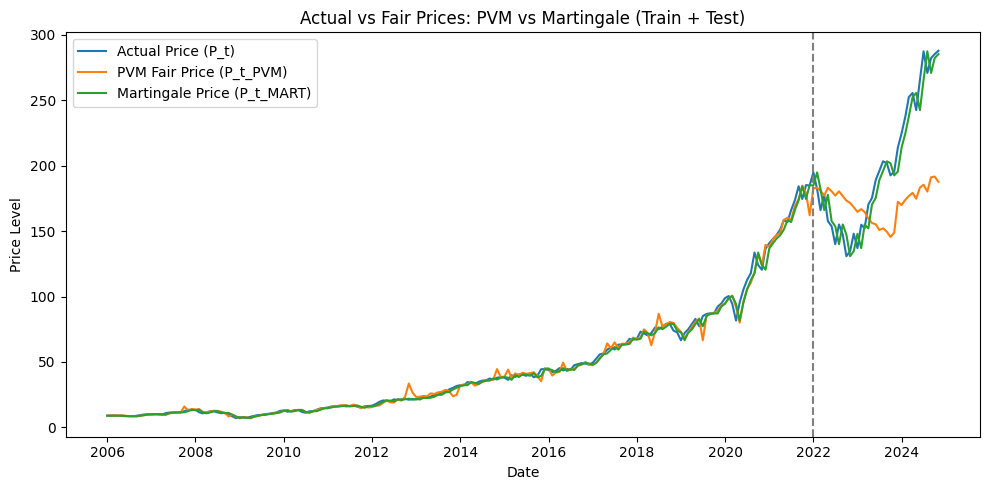

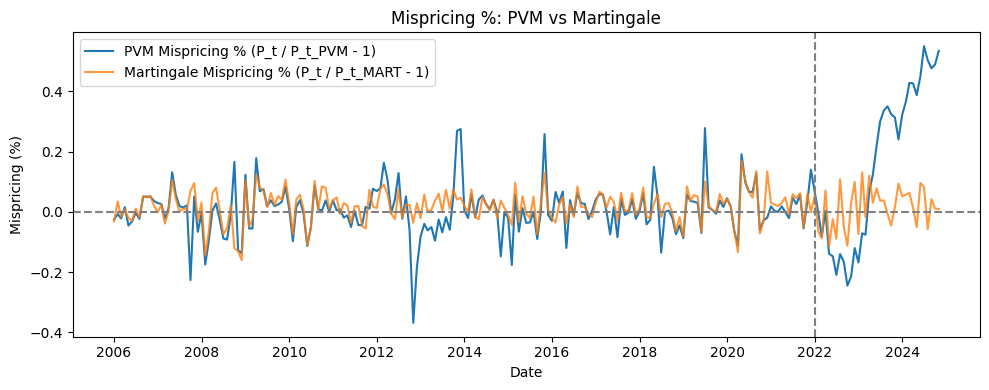

In [65]:

combined_results = combined_results.sort_index()

combined_results["P_t_MART"] = combined_results["P_t"].shift(1)

combined_results["mispricing_pct_MART"] = combined_results["P_t"] / combined_results["P_t_MART"] - 1

plot_df = (
    combined_results.loc["2006-01-01":]
    .dropna(subset=["P_t", "P_t_PVM", "P_t_MART", "mispricing_pct", "mispricing_pct_MART"])
    .copy()
)

plt.figure(figsize=(10, 5))
plt.plot(plot_df.index, plot_df["P_t"],       label="Actual Price (P_t)")
plt.plot(plot_df.index, plot_df["P_t_PVM"],   label="PVM Fair Price (P_t_PVM)")
plt.plot(plot_df.index, plot_df["P_t_MART"],  label="Martingale Price (P_t_MART)")

split_date = test_results.index.min()
plt.axvline(split_date, linestyle="--", color="gray")

plt.title("Actual vs Fair Prices: PVM vs Martingale (Train + Test)")
plt.xlabel("Date")
plt.ylabel("Price Level")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(plot_df.index, plot_df["mispricing_pct"],        label="PVM Mispricing % (P_t / P_t_PVM - 1)")
plt.plot(plot_df.index, plot_df["mispricing_pct_MART"],   label="Martingale Mispricing % (P_t / P_t_MART - 1)", alpha=0.8)

plt.axhline(0, linestyle="--", color="gray")
plt.axvline(split_date, linestyle="--", color="gray")

plt.title("Mispricing %: PVM vs Martingale")
plt.xlabel("Date")
plt.ylabel("Mispricing (%)")
plt.legend()
plt.tight_layout()
plt.show()


In [67]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, coint
import os as os
import matplotlib.pyplot as plt

Root_dir = ".."
Data_dir = os.path.join(Root_dir, "data_extraction", "raw_df")

def compute_metrics(df, y_col, yhat_col, label):
    tmp = df.dropna(subset=[y_col, yhat_col]).copy()
    y = tmp[y_col]
    yhat = tmp[yhat_col]

    rmse = np.sqrt(np.mean((yhat - y) ** 2))
    mape = np.mean(np.abs((yhat - y) / y)) * 100
    corr = y.corr(yhat)
    ss_res = np.sum((y - yhat) ** 2)
    ss_tot = np.sum((y - y.mean()) ** 2)
    r2 = 1 - ss_res / ss_tot

    print(f"\n=== {label} ===")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAPE: {mape:.2f}%")
    print(f"Correlation ({y_col} vs {yhat_col}): {corr:.4f}")
    print(f"Pseudo R²: {r2:.4f}")

ndx_df = pd.read_csv(
    os.path.join(Data_dir, "nasdaq_monthly_df.csv"),
    parse_dates=["Date"]
)
ndx_df = ndx_df[["Date", "Close"]]
ndx_df = ndx_df.set_index("Date").sort_index()
ndx_df = ndx_df.rename(columns={"Close": "NDX_actual"})

combined_results = combined_results.sort_index()
ndx_joined = combined_results.join(ndx_df[["NDX_actual"]], how="inner")

ndx_joined["NDX_fair_PVM"] = (
    1328.3552 + 68.7614 * ndx_joined["P_t_PVM"]
)

ndx_joined["NDX_fair_MART"] = (
    1328.3552 + 68.7614 * ndx_joined["P_t_MART"]
)

ndx_joined["NDX_equiv_from_synth"] = (
    1328.3552 + 68.7614 * ndx_joined["P_t"]
)

ndx_joined["NDX_mispricing_PVM"] = (
    ndx_joined["NDX_actual"] - ndx_joined["NDX_fair_PVM"]
)
ndx_joined["NDX_mispricing_pct_PVM"] = (
    ndx_joined["NDX_actual"] / ndx_joined["NDX_fair_PVM"] - 1
)

ndx_joined["NDX_mispricing_MART"] = (
    ndx_joined["NDX_actual"] - ndx_joined["NDX_fair_MART"]
)
ndx_joined["NDX_mispricing_pct_MART"] = (
    ndx_joined["NDX_actual"] / ndx_joined["NDX_fair_MART"] - 1
)

train_ndx = ndx_joined[ndx_joined["sample"] == "train"]
test_ndx  = ndx_joined[ndx_joined["sample"] == "test"]

compute_metrics(train_ndx, "NDX_actual", "NDX_fair_PVM",  "TRAIN NDX PVM")
compute_metrics(test_ndx,  "NDX_actual", "NDX_fair_PVM",  "TEST NDX PVM")

compute_metrics(train_ndx, "NDX_actual", "NDX_fair_MART", "TRAIN NDX MART")
compute_metrics(test_ndx,  "NDX_actual", "NDX_fair_MART", "TEST NDX MART")

ndx_pvm_results = ndx_joined[[
    "NDX_actual",
    "NDX_fair_PVM",
    "NDX_fair_MART",
    "NDX_mispricing_PVM",
    "NDX_mispricing_pct_PVM",
    "NDX_mispricing_MART",
    "NDX_mispricing_pct_MART",
    "P_t",
    "P_t_PVM",
    "P_t_MART",
    "sample"
]].copy()

print(ndx_pvm_results.head())
ndx_pvm_results.to_csv("FVM_data/ndx_pvm_results.csv")





=== TRAIN NDX PVM ===
RMSE: 832.2317
MAPE: 15.43%
Correlation (NDX_actual vs NDX_fair_PVM): 0.9909
Pseudo R²: 0.9438

=== TEST NDX PVM ===
RMSE: 3500.9679
MAPE: 18.07%
Correlation (NDX_actual vs NDX_fair_PVM): 0.3200
Pseudo R²: -0.4017

=== TRAIN NDX MART ===
RMSE: 806.6744
MAPE: 13.84%
Correlation (NDX_actual vs NDX_fair_MART): 0.9948
Pseudo R²: 0.9473

=== TEST NDX MART ===
RMSE: 1080.2450
MAPE: 6.40%
Correlation (NDX_actual vs NDX_fair_MART): 0.9524
Pseudo R²: 0.8665
             NDX_actual  NDX_fair_PVM  NDX_fair_MART  NDX_mispricing_PVM  \
Date                                                                       
2003-01-01   983.049988   1673.745774            NaN         -690.695786   
2003-02-01  1009.739990   1749.817671    1662.530783         -740.077681   
2003-03-01  1018.659973   1635.210098    1644.956684         -616.550125   
2003-04-01  1106.060059   1629.681923    1648.275349         -523.621864   
2003-05-01  1197.890015   1642.093371    1653.043970         -444.20

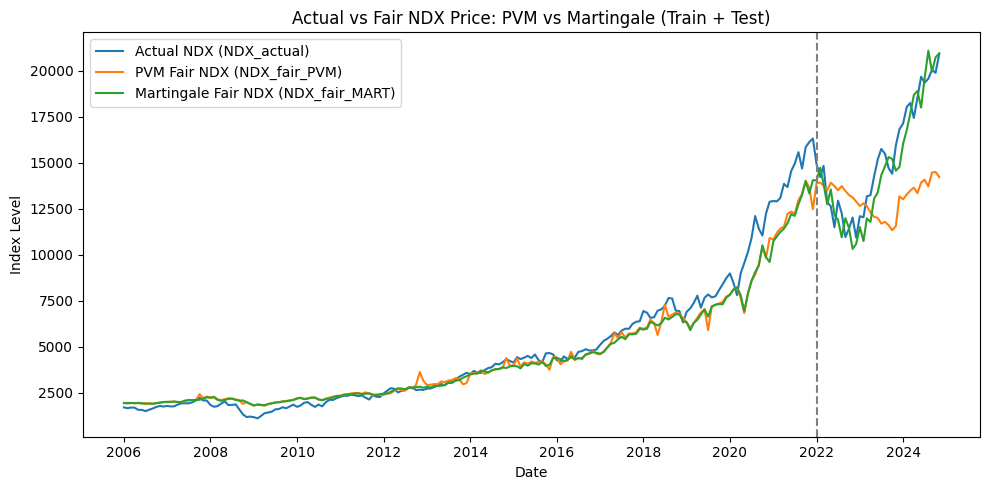

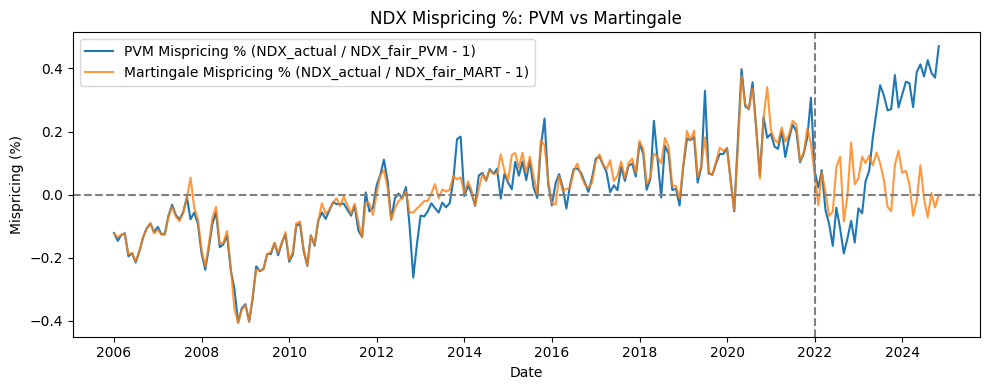

In [68]:
plot_df = ndx_pvm_results.loc["2006-01-01":].dropna(
    subset=["NDX_actual", "NDX_fair_PVM", "NDX_fair_MART"]
).copy()

split_date = ndx_pvm_results[ndx_pvm_results["sample"] == "test"].index.min()

plt.figure(figsize=(10, 5))
plt.plot(plot_df.index, plot_df["NDX_actual"],     label="Actual NDX (NDX_actual)")
plt.plot(plot_df.index, plot_df["NDX_fair_PVM"],   label="PVM Fair NDX (NDX_fair_PVM)")
plt.plot(plot_df.index, plot_df["NDX_fair_MART"],  label="Martingale Fair NDX (NDX_fair_MART)")
plt.axvline(split_date, linestyle="--", color="gray")
plt.title("Actual vs Fair NDX Price: PVM vs Martingale (Train + Test)")
plt.xlabel("Date")
plt.ylabel("Index Level")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(plot_df.index, plot_df["NDX_mispricing_pct_PVM"],
         label="PVM Mispricing % (NDX_actual / NDX_fair_PVM - 1)")
plt.plot(plot_df.index, plot_df["NDX_mispricing_pct_MART"],
         label="Martingale Mispricing % (NDX_actual / NDX_fair_MART - 1)",
         alpha=0.8)
plt.axhline(0, linestyle="--", color="gray")
plt.axvline(split_date, linestyle="--", color="gray")
plt.title("NDX Mispricing %: PVM vs Martingale")
plt.xlabel("Date")
plt.ylabel("Mispricing (%)")
plt.legend()
plt.tight_layout()
plt.show()